In [1]:
import os
from dotenv import load_dotenv
import openai
import csv
import pandas as pd
from openai import OpenAI
import json


In [2]:
# Load environment variables
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("No OpenAI API key found. Check your .env file.")

In [3]:
# Set the API key for OpenAI
openai.api_key = openai_api_key

In [4]:
reviews = [
    "Absolutely epic! Building this set was like stepping back into my childhood dreams. The nostalgia and intricate design deserve a five-star rating!",
    "The attention to detail is phenomenal, yet the assembly was a lengthy endeavor. Nonetheless, the final result is undoubtedly worth the time and effort.",
    "Disappointed due to missing pieces in my set, which led to a frustrating building experience. Unfortunately, I can only give it 2 stars.",
   "Incredible design that captivated both my kids and me. We had a blast piecing it together. I highly recommend it for family bonding time.",
   "Its enormous size is overwhelming and consumes a lot of space. In hindsight, I regret the purchase due to its impracticality.",
   "A true masterpiece that resonates with any Star Wars aficionado. The price is steep, but the authenticity and quality justify the cost.",
   "The instructions were perplexing and at times, overwhelming. This set is challenging and requires patience and dedication.",
   "I'm halfway through the build, and it already looks stunning. It's a challenging project, but incredibly rewarding and enjoyable.",
   "This set is quite complex and not really suitable for children. It leans more towards adult Lego enthusiasts due to its intricate details.",
   "Absolutely love it! It's the perfect crowning jewel for my Star Wars collection and a testament to my fandom.",
   "The build is decent, but it falls short of my expectations in terms of interactive features, especially considering the price point.",
   "The set broke apart after just a week, which is disappointing and raises questions about the quality, given the high price.",
   "Building this set felt like a journey through the galaxy, mirroring the epic scope of the Star Wars movies. A truly epic experience.",
   "I found it to be overrated. At the end of the day, it's a collection of bricks that doesn't live up to the hype.",
   "Building this was magical! It feels like I've constructed my very own Death Star. A must-have for fans, and may the force be with all builders!",
   "The instructions were clear and concise, and the pieces fit together seamlessly. It was a thoroughly rewarding building experience.",
   "I was expecting a greater variety of minifigures and felt a bit let down. It's a good set, but it could have been better in this regard.",
   "Took me longer to build than I anticipated, but now it's a stunning centerpiece in my room. It's a remarkable display piece.",
   "It's an okay set, but in my opinion, there are better Lego sets available that offer more value and engagement.",
   "Absolutely stunning once assembled. However, builders should be prepared for a lengthy and demanding construction journey."
]


In [5]:
client = OpenAI()
def get_completion_from_messages(messages, model="gpt-3.5-turbo", temperature=0):
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )

    return response.choices[0].message.content


In [6]:
# aspect extraction: system message
delimiter = "####"
system_message_aspect = f"""
You will be provided with customer reviews of a Lego set. \
The review will be delimited with {delimiter} characters. \
Your task is to segment each review into aspects. \
Output a python dictionary, which has the following format \
review = [review: "...", "aspect1" : "...", "aspect2" : "..." \
add as many aspects as you need for each review \
also add the review itself as a string \
Each aspect should contain a new dimension, functionality, or feature of the Lego set. \
Store the aspects as a string. \
For example, if the review is 'The set is expensive, but it looks great.', \
then the aspects are "price": "The set is expensive" and "appearance" : "but it looks great". \
If possible, use one of the following categories for the aspects: \
Build Quality
Complexity
Design
Educational Value
Entertainment Value
Instruction Clarity
Interactivity
Nostalgia
Price
Size
Age Suitability
Minifigures
Part Availability
Durability
Collectibility
Packaging
Assembly Time
Replay Value

If none of the above categories are suitable, you can use your own categories. \
If you are unable to segment the review into aspects, output an empty string. \
Only ouput the dictionary, with nothing else. \
"""

In [7]:
# sentiment analysis: system message
system_message_sentiment = f"""
You will be provided with a python dictionary of customer reviews of a Lego set. \
Each dictionary contains the whole review as well as their different aspects. \
The review will be delimited with {delimiter} characters. \
Your task is to analyze the sentiment of each aspect of the review individually. \
Output your results in json format with the following structure: \
{{
    "review": "Absolutely epic! Building this set was like stepping back into my childhood dreams. The nostalgia and intricate design deserve a five-star rating!",
    "Nostalgia": "Positive",
    "Design": "Positive"
}} \
add as many aspects as you need for each review \
also add the review itself as a string \
The sentiment has to be one of the following: \
Positive
Neutral
Negative
If you are unable to analyze the sentiment of the aspect, output an empty string. \

"""


In [8]:
# loop through all reviews

# Initializing a list to store aspects of all reviews
all_aspects = []

for i, review in enumerate(reviews):
    print(f"Processing review {i+1}/{len(reviews)}")

    messages_aspect = [
        {'role': 'system', 'content': system_message_aspect},
        {'role': 'user', 'content': f"{delimiter}{review}{delimiter}"}
    ]

    aspects = get_completion_from_messages(messages_aspect)

    #print(f"Received aspects for review {i+1}: {aspects}") # Uncomment to use for debugging

    # Append the aspects of this review to the list
    all_aspects.append(aspects)


Processing review 1/20
Processing review 2/20
Processing review 3/20
Processing review 4/20
Processing review 5/20
Processing review 6/20
Processing review 7/20
Processing review 8/20
Processing review 9/20
Processing review 10/20
Processing review 11/20
Processing review 12/20
Processing review 13/20
Processing review 14/20
Processing review 15/20
Processing review 16/20
Processing review 17/20
Processing review 18/20
Processing review 19/20
Processing review 20/20


In [9]:
# Convert aspects to a string
for aspect_dict in all_aspects:
    aspect_string = json.dumps(aspect_dict)

In [10]:
final_outputs = []

for aspect_dict in all_aspects:
    # Convert each aspect dictionary to a JSON string
    aspect_string = json.dumps(aspect_dict)
    
    # Prepare the message for sentiment analysis
    messages_sentiment = [
        {'role': 'system', 'content': system_message_sentiment},
        {'role': 'user', 'content': f"{delimiter}{aspect_string}{delimiter}"}
    ]
    
    # Analyze sentiment for each set of aspects
    sentiment_analysis = get_completion_from_messages(messages_sentiment)

    # Store the final response
    final_outputs.append(sentiment_analysis)


In [11]:
def convert_reviews_to_sentiment(final_outputs):
    sentiment_results = []

    for review_str in final_outputs:
        try:
            review_dict = eval(review_str)  # Convert the string to a dictionary
            sentiment_entry = {"Review": review_dict["review"]}  # Initialize the dictionary for this review
            for key, value in review_dict.items():
                if key != "review":
                    sentiment_entry[key] = value  # Add sentiment attributes (excluding "review")
            sentiment_results.append(sentiment_entry)  # Append the sentiment entry to the list
        except Exception as e:
            print(f"Error converting string to sentiment entry: {e}")

    return sentiment_results


# Convert final_outputs to sentiment_results
sentiment_results = convert_reviews_to_sentiment(final_outputs)


In [12]:
# Open a file for writing
with open('sentiment_results.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)

    # Write the header with all categories dynamically
    header = ['Review'] + list(set(category for review in sentiment_results for category in review.keys() if category != 'Review'))
    writer.writerow(header)

    # Iterate over sentiment_results and write rows
    for review_data in sentiment_results:
        row = [review_data.get('Review', '')]  # Start with the review text
        for category in header[1:]:  # Exclude the 'Review' column
            row.append(review_data.get(category, ''))
        writer.writerow(row)


In [13]:
pip install matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.9/158.9 kB 2.8 MB/s eta 0:00:00a 0:00:01
  Using cached importlib_resources-6.1.1-py3-none-any.whl.metadata (4.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 41.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 37.0 MB/s eta 0:00:0000:0100:01
Using cached importlib_resources-6.1.1-py3-none-any.whl (33 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 4.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the data from the CSV file
df = pd.read_csv('sentiment_results.csv')

# Prepare a dictionary to hold the sentiment counts
overall_sentiment_counts = {'Positive': 0, 'Neutral': 0, 'Negative': 0}
category_sentiment_counts = {}

# Iterate through each row in the DataFrame to populate our dictionaries
for _, row in df.iterrows():
    for category in row.index[1:]:  # Skip the 'Review' column
        sentiment = row[category]
        if pd.isnull(sentiment):  # Skip empty values
            continue
        
        # Update overall sentiment counts
        if sentiment in overall_sentiment_counts:
            overall_sentiment_counts[sentiment] += 1
        
        # Update category-specific sentiment counts
        if category not in category_sentiment_counts:
            category_sentiment_counts[category] = {'Positive': 0, 'Neutral': 0, 'Negative': 0}
        category_sentiment_counts[category][sentiment] += 1


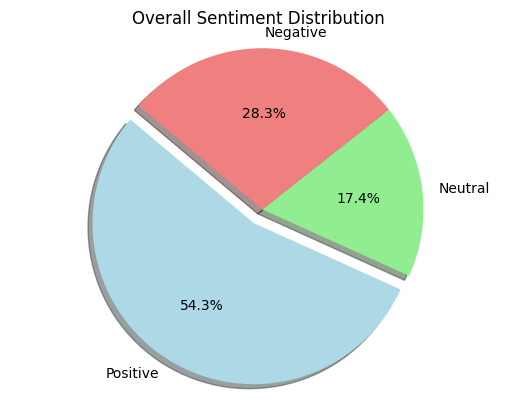

In [15]:
def plot_overall_sentiment_distribution(overall_sentiment_counts):
    labels = overall_sentiment_counts.keys()
    sizes = overall_sentiment_counts.values()
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    explode = (0.1, 0, 0)  # explode the 1st slice (Positive)

    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title("Overall Sentiment Distribution")
    plt.show()

plot_overall_sentiment_distribution(overall_sentiment_counts)


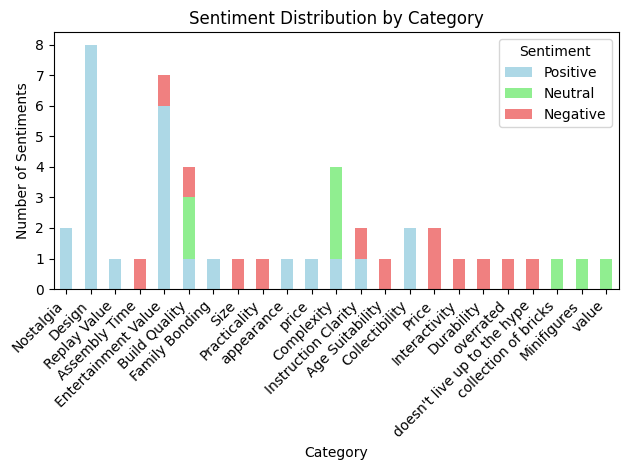

In [16]:
def plot_sentiment_distribution_by_category(category_sentiment_counts):
    categories = list(category_sentiment_counts.keys())
    sentiments = ['Positive', 'Neutral', 'Negative']

    # Prepare data
    data = {sentiment: [category_sentiment_counts[category][sentiment] for category in categories] for sentiment in sentiments}

    df = pd.DataFrame(data, index=categories)

    # Plot
    df.plot(kind='bar', stacked=True, color=['lightblue', 'lightgreen', 'lightcoral'])
    plt.title("Sentiment Distribution by Category")
    plt.xlabel("Category")
    plt.ylabel("Number of Sentiments")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Sentiment")
    plt.tight_layout()  # Adjust layout to not cut off labels
    plt.show()

plot_sentiment_distribution_by_category(category_sentiment_counts)
